<a href="https://colab.research.google.com/github/Shahzeb999/KidneyTumorSegmentation/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Kits')

In [ ]:
cd kits19

/content/drive/MyDrive/Kits/kits19


In [ ]:
from utils import plot_sample

In [ ]:
import os
import glob
import cv2
import imageio
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from matplotlib.pyplot import figure

import cv2 as cv
import numpy as np
import math
import time
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [ ]:
import matplotlib.pyplot as plt

def vis_im(array_):
    array = np.rot90(np.array(array_), k=-1)
    return array

def plot_mask_slice(mask_slice, color_map='nipy_spectral'):
    fig = plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(vis_im(mask_slice), alpha=0.5, cmap=color_map)
    plt.title('Mask Slice')
    plt.axis('off')
    plt.show()

def plot_image(sample_slice):
    fig = plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(sample_slice, cmap='gray')
    plt.axis('off')
# Assuming you have 'sample_mask' and 'sample' variables defined
# and 'sample_mask' is a 3D array containing the mask data
# and 'sample' is the index of the slice to visualize

In [ ]:
# Read NIfTI files
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array), k=1, axes=(0, 2))
    return array

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/Kits/kits19/final_df.csv')

In [ ]:
final_df['dirname_input'] = final_df['dirname_input'].str.replace('\\', '/')

# Convert backslashes to forward slashes in the 'dirname_segmentation' column
final_df['dirname_segmentation'] = final_df['dirname_segmentation'].str.replace('\\', '/')

<ipython-input-10-a7a07cfcd7cc>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_df['dirname_input'] = final_df['dirname_input'].str.replace('\\', '/')
<ipython-input-10-a7a07cfcd7cc>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_df['dirname_segmentation'] = final_df['dirname_segmentation'].str.replace('\\', '/')


In [ ]:
final_df.head()

dirname_input        filename dirname_segmentation         filename_seg
0  data/case_00000  imaging.nii.gz      data/case_00000  segmentation.nii.gz
1  data/case_00001  imaging.nii.gz      data/case_00001  segmentation.nii.gz
2  data/case_00002  imaging.nii.gz      data/case_00002  segmentation.nii.gz
3  data/case_00003  imaging.nii.gz      data/case_00003  segmentation.nii.gz
4  data/case_00004  imaging.nii.gz      data/case_00004  segmentation.nii.gz

In [ ]:
sample = 0

sample_ct = read_nii(final_df.loc[sample, 'dirname_input'] + '/' + final_df.loc[sample, 'filename'])
sample_mask = read_nii(final_df.loc[sample, 'dirname_segmentation'] + '/' + final_df.loc[sample, 'filename_seg'])

print(f"CT SHAPE: {sample_ct.shape}\nMask Shape: {sample_mask.shape}")

CT SHAPE: (512, 512, 611)
Mask Shape: (512, 512, 611)


In [ ]:
def CropImageLeft(Image):
    crop_start_left = 90
    crop_start_right = 258
    crop_start_top = 225
    crop_start_bottom = 393
#crop_end = crop_start + 400
    cropped_image = Image[crop_start_top:crop_start_bottom, crop_start_left:crop_start_right]
    return cropped_image

def CropImageRight(Image):
    crop_start_left = 276
    crop_start_right = 444
    crop_start_top = 255
    crop_start_bottom = 423
#crop_end = crop_start + 400
    cropped_image = Image[crop_start_top:crop_start_bottom, crop_start_left:crop_start_right]
    return cropped_image

numpy.ndarray

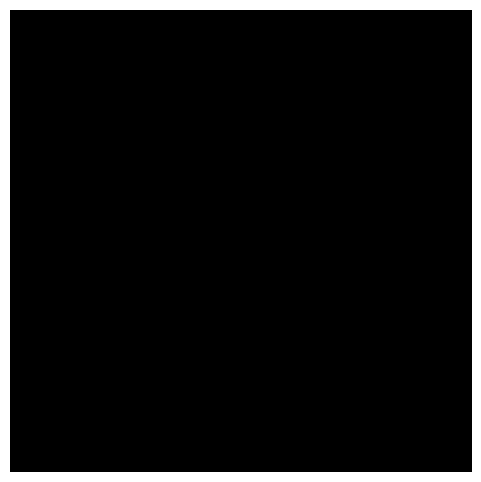

In [ ]:
idx = 0
mask = read_nii(final_df.loc[idx, 'dirname_segmentation'] + '/' + final_df.loc[idx, 'filename_seg'])
mask_slice = vis_im(mask[..., 0])
Filter = CropImageLeft(mask_slice)

plot_image(Filter)
type(Filter)

In [ ]:
# Preprocessing functions

def normalize_image(image):
    return image / 255.0

def preprocess_mask(mask):
    return (mask).astype(np.float32)

def preprocess_input(image):
    image = normalize_image(image)
    return tf.expand_dims(image, axis=-1)

def preprocess_data(image, mask):
    image = preprocess_input(image)
    mask = preprocess_mask(mask)
    return image, mask

In [ ]:
import os

# Define the directory paths for saving train images and masks
train_images_dir = "train_images_Left"
train_masks_dir = "train_masks_Left"

# Create the directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)

for idx in range(0,200,2):
    # idx = 20

    ct = read_nii(final_df.loc[idx, 'dirname_input'] + '/' + final_df.loc[idx, 'filename'])
    mask = read_nii(final_df.loc[idx, 'dirname_segmentation'] + '/' + final_df.loc[idx, 'filename_seg'])

    for sample in range(0, ct.shape[2],3):
        mask_slice = vis_im(mask[..., sample])
        mask_slice = CropImageLeft(mask_slice)

        if not np.array_equal(mask_slice, Filter):
            sample_slice = vis_im(ct[..., sample]).astype(np.float32)
            sample_slice = CropImageLeft(sample_slice)
            enhanced_image = sample_slice  # fuzzyenhancement(sample_slice)

            data = preprocess_data(enhanced_image, mask_slice)

            # Save the data as individual files in the train_images and train_masks directories
            image_filename = f"{idx}_sample_{sample}_image.npy"
            mask_filename = f"{idx}_sample_{sample}_mask.npy"

            image_filepath = os.path.join(train_images_dir, image_filename)
            mask_filepath = os.path.join(train_masks_dir, mask_filename)

            np.save(image_filepath, data[0])  # Save the image data
            np.save(mask_filepath, data[1])  # Save the mask data


In [ ]:
import os

# Define the directory paths for saving train images and masks
train_images_dir = "/content/drive/MyDrive/Kits/kits19/train_images_Left"
train_masks_dir = "/content/drive/MyDrive/Kits/kits19/train_masks_Left"

def load_data(images_dir, masks_dir):
    image_filenames = os.listdir(images_dir)
    mask_filenames = os.listdir(masks_dir)

    # Sort the filenames to ensure corresponding images and masks match
    image_filenames.sort()
    mask_filenames.sort()

    images = []
    masks = []

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        image = np.load(os.path.join(images_dir, img_file))
        mask = np.load(os.path.join(masks_dir, mask_file))

        # Perform any necessary preprocessing (e.g., normalization) here
        # ...

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load and preprocess the data
images, masks = load_data(train_images_dir, train_masks_dir)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate

# Assuming your train_images and train_masks are numpy arrays with the shape (num_samples, height, width, num_channels)

# Define the number of classes for segmentation
num_classes = 3

# Define the input shape of the images (height, width, num_channels)
input_shape = (138, 138, 1)

# Scaled Dot-Product Attention Layer
def scaled_dot_product_attention(q, k, v):
    temp = tf.matmul(q, k, transpose_b=True)
    scale = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = temp / tf.math.sqrt(scale)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output

# Self-Attention Block
def self_attention(input_tensor, filters):
    q = Conv2D(filters // 8, (1, 1))(input_tensor)
    k = Conv2D(filters // 8, (1, 1))(input_tensor)
    v = Conv2D(filters, (1, 1))(input_tensor)
    attention = scaled_dot_product_attention(q, k, v)
    return attention

# U-Net Model with Self-Attention
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge with Self-Attention
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    attention_conv4 = self_attention(conv4, 512)

    # Decoder with Self-Attention
    up5 = tf.image.resize(attention_conv4, (conv3.shape[1], conv3.shape[2]), method='nearest')
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    attention_conv5 = self_attention(conv5, 256)

    up6 = tf.image.resize(attention_conv5, (conv2.shape[1], conv2.shape[2]), method='nearest')
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    attention_conv6 = self_attention(conv6, 128)

    up7 = tf.image.resize(attention_conv6, (conv1.shape[1], conv1.shape[2]), method='nearest')
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    attention_conv7 = self_attention(conv7, 64)

    # Output layer (3 classes for segmentation)
    outputs = Conv2D(num_classes, 1, activation='softmax')(attention_conv7)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model with Self-Attention
model = unet_model(input_shape, num_classes)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 138, 138, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 138, 138, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 138, 138, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
import tensorflow as tf

# Replace 'path_to_model_directory' with the actual path where your model is saved
model_directory = '/content/drive/MyDrive/Kits/kits19/model_L.h5'

# Load the model from the specified directory
model = tf.keras.models.load_model(model_directory)

In [ ]:
predicted_masks = np.argmax(model.predict(images), axis=-1)

65/65 [==============================] - 36s 345ms/step


In [ ]:
import numpy as np

def dice_coefficient(predicted_mask, ground_truth_mask, class_label):
    # Create binary masks for the predicted and ground truth masks based on the class label
    binary_predicted_mask = (predicted_mask == class_label).astype(np.float32)
    binary_ground_truth_mask = (ground_truth_mask == class_label).astype(np.float32)

    # Check if the shapes of the binary masks match
    if binary_predicted_mask.shape != binary_ground_truth_mask.shape:
        raise ValueError("Predicted mask and ground truth mask must have the same shape.")

    # Flatten the binary masks to 1D arrays
    predicted_flat = binary_predicted_mask.flatten()
    ground_truth_flat = binary_ground_truth_mask.flatten()

    # Compute the intersection, total pixels, and predicted pixels for the given class
    intersection = np.sum(predicted_flat * ground_truth_flat)
    total_pixels = np.sum(ground_truth_flat)
    predicted_pixels = np.sum(predicted_flat)

    # Calculate the Dice coefficient for the given class
    dice = 2.0 * intersection / (total_pixels + predicted_pixels + 1e-7)  # Add a small value to avoid division by zero

    return dice

def average_dice_score(images, ground_truth_masks, predicted_masks, class_label):
    total_dice = 0.0
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        ground_truth_mask = ground_truth_masks[i]
        predicted_mask = predicted_masks[i]

        # Apply thresholding to the predicted mask
        thresholded_mask = predicted_mask

        dice = dice_coefficient(thresholded_mask, ground_truth_mask, class_label)
        total_dice += dice

    average_dice = total_dice / num_images
    return average_dice

# Example usage:
# Assuming you have lists of images, ground_truth_masks, and predicted_masks
# For simplicity, I assume you have two lists of 5 images each
def Dice_score(images,ground_truth_masks,predicted_masks):

  # Calculate the average Dice score for class 1
  class_label = 1
  average_dice_class1 = average_dice_score(images, ground_truth_masks, predicted_masks, class_label)
  print(f"Average Dice score for Kidney: {average_dice_class1:.4f}")

  # Calculate the average Dice score for class 2 (change the class_label as needed)
  class_label = 2
  average_dice_class2 = average_dice_score(images, ground_truth_masks, predicted_masks, class_label)
  print(f"Average Dice score for Kidney Tumor: {average_dice_class2:.4f}")

In [ ]:
print("Train Data")
Dice_score(images,masks,predicted_masks)

Train Data
Average Dice score for Kidney: 0.9094
Average Dice score for Kidney Tumor: 0.1004


In [ ]:
del images
del masks

In [ ]:
import os

# Define the directory paths for saving train images and masks
train_images_dir = "test_images_Left"
train_masks_dir = "test_masks_Left"

# Create the directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)

for idx in range(200,210):
    # idx = 20

    ct = read_nii(final_df.loc[idx, 'dirname_input'] + '/' + final_df.loc[idx, 'filename'])
    mask = read_nii(final_df.loc[idx, 'dirname_segmentation'] + '/' + final_df.loc[idx, 'filename_seg'])

    for sample in range(0, ct.shape[2],3):
        mask_slice = vis_im(mask[..., sample])
        mask_slice = CropImageLeft(mask_slice)

        if not np.array_equal(mask_slice, Filter):
            sample_slice = vis_im(ct[..., sample]).astype(np.float32)
            sample_slice = CropImageLeft(sample_slice)
            enhanced_image = sample_slice  # fuzzyenhancement(sample_slice)

            data = preprocess_data(enhanced_image, mask_slice)

            # Save the data as individual files in the train_images and train_masks directories
            image_filename = f"{idx}_sample_{sample}_image.npy"
            mask_filename = f"{idx}_sample_{sample}_mask.npy"

            image_filepath = os.path.join(train_images_dir, image_filename)
            mask_filepath = os.path.join(train_masks_dir, mask_filename)

            np.save(image_filepath, data[0])  # Save the image data
            np.save(mask_filepath, data[1])  # Save the mask data


In [ ]:
import os

# Define the directory paths for saving train images and masks
test_images_dir = "/content/drive/MyDrive/Kits/kits19/test_images_Left"
test_masks_dir = "/content/drive/MyDrive/Kits/kits19/test_masks_Left"

def load_data(images_dir, masks_dir):
    image_filenames = os.listdir(images_dir)
    mask_filenames = os.listdir(masks_dir)

    # Sort the filenames to ensure corresponding images and masks match
    image_filenames.sort()
    mask_filenames.sort()

    images = []
    masks = []

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        image = np.load(os.path.join(images_dir, img_file))
        mask = np.load(os.path.join(masks_dir, mask_file))

        # Perform any necessary preprocessing (e.g., normalization) here
        # ...

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load and preprocess the data
test_images, test_masks = load_data(test_images_dir, test_masks_dir)

In [ ]:
test_masks.shape

(119, 168, 168)

In [ ]:
test_images.shape

(119, 168, 168, 1)

In [ ]:
predicted_masks_test = np.argmax(model.predict(test_images), axis=-1)

4/4 [==============================] - 23s 2s/step


In [ ]:
print("Test Data")
Dice_score(test_images,test_masks,predicted_masks_test)

Test Data
Average Dice score for Kidney: 0.9097
Average Dice score for Kidney Tumor: 0.0172


In [ ]:
def visualize_segmentation(images, model, original_masks):
    # Predict masks for the test images
    predicted_masks = model.predict(images)

    # Convert the predicted masks to class labels (0, 1, 2, etc.) by taking the argmax
    predicted_labels = np.argmax(predicted_masks, axis=-1)

    # Visualize the segmentation
    num_samples = images.shape[0]
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 4, 2)
        plt.imshow(predicted_labels[i], cmap='jet')  # Using 'jet' colormap for visualization
        plt.title('Predicted Mask')
        plt.axis('off')

        # Overlay the predicted mask on the original image
        plt.subplot(1, 4, 3)
        plt.imshow(images[i], cmap='gray')
        plt.imshow(predicted_labels[i], alpha=0.5, cmap='jet')
        plt.title('Overlay (Predicted)')
        plt.axis('off')

        # Original mask
        if original_masks is not None:

            plt.subplot(1, 4, 4)
            plt.imshow(original_masks[i], cmap='cool')
            plt.title('Original Mask')
            plt.axis('off')

        plt.show()

In [ ]:
indexes = []
for i in range(100):
  if len(np.unique(test_masks[i]))==3:
    indexes.append(i)

1/1 [==============================] - 2s 2s/step


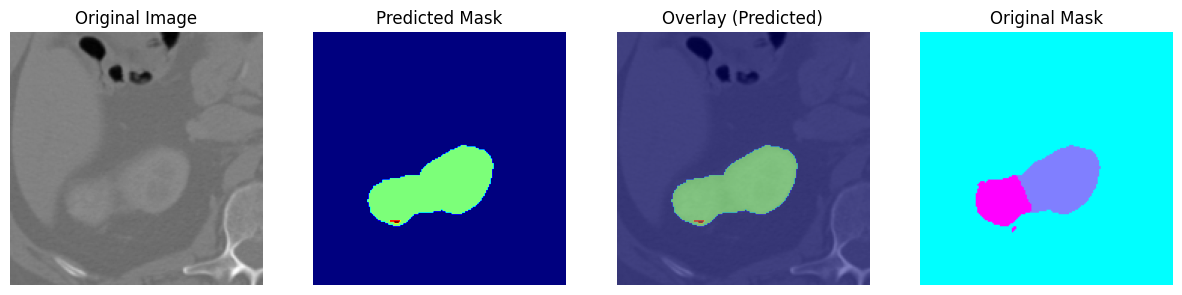

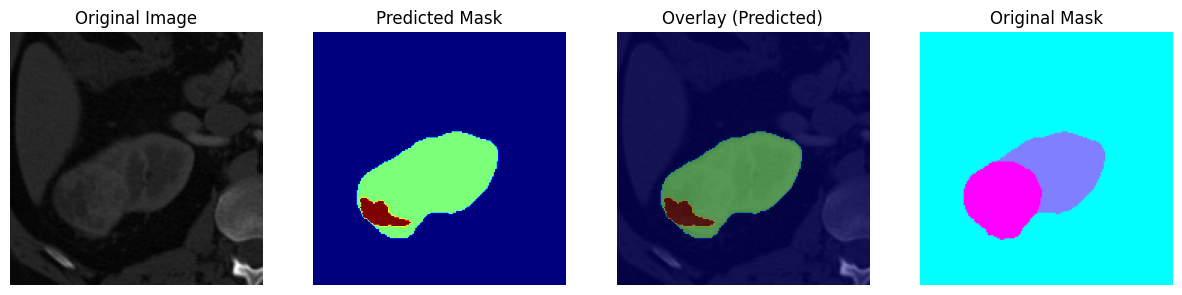

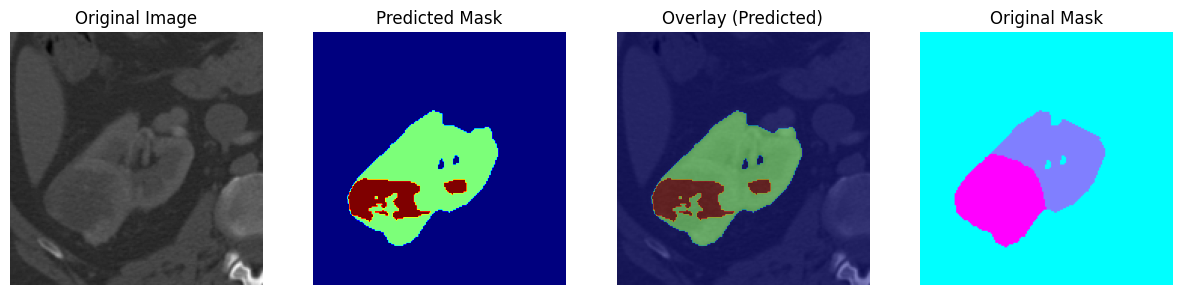

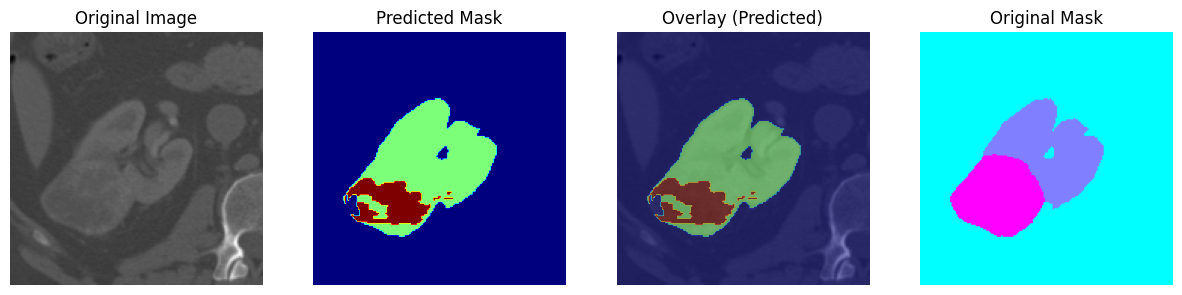

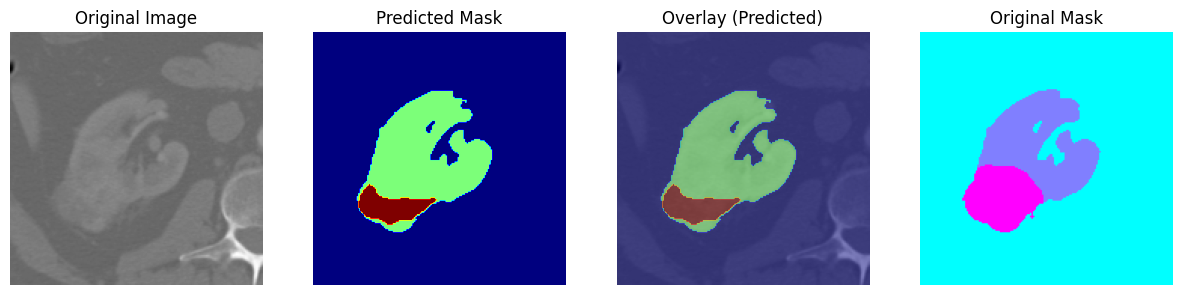

In [ ]:
visualize_segmentation(test_images[indexes], model,test_masks[indexes])

In [ ]:
import os

# Define the directory paths for saving train images and masks
train_images_dir = "train_images_Right"
train_masks_dir = "train_masks_Right"

# Create the directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)

for idx in range(0,200,2):
    # idx = 20

    ct = read_nii(final_df.loc[idx, 'dirname_input'] + '/' + final_df.loc[idx, 'filename'])
    mask = read_nii(final_df.loc[idx, 'dirname_segmentation'] + '/' + final_df.loc[idx, 'filename_seg'])

    for sample in range(0, ct.shape[2],3):
        mask_slice = vis_im(mask[..., sample])
        mask_slice = CropImageRight(mask_slice)

        if not np.array_equal(mask_slice, Filter):
            sample_slice = vis_im(ct[..., sample]).astype(np.float32)
            sample_slice = CropImageRight(sample_slice)
            enhanced_image = sample_slice  # fuzzyenhancement(sample_slice)

            data = preprocess_data(enhanced_image, mask_slice)

            # Save the data as individual files in the train_images and train_masks directories
            image_filename = f"{idx}_sample_{sample}_image.npy"
            mask_filename = f"{idx}_sample_{sample}_mask.npy"

            image_filepath = os.path.join(train_images_dir, image_filename)
            mask_filepath = os.path.join(train_masks_dir, mask_filename)

            np.save(image_filepath, data[0])  # Save the image data
            np.save(mask_filepath, data[1])  # Save the mask data


In [ ]:
import os

# Define the directory paths for saving train images and masks
train_images_dir = "/content/drive/MyDrive/Kits/kits19/train_images_Right"
train_masks_dir = "/content/drive/MyDrive/Kits/kits19/train_masks_Right"

def load_data(images_dir, masks_dir):
    image_filenames = os.listdir(images_dir)
    mask_filenames = os.listdir(masks_dir)

    # Sort the filenames to ensure corresponding images and masks match
    image_filenames.sort()
    mask_filenames.sort()

    images = []
    masks = []

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        image = np.load(os.path.join(images_dir, img_file))
        mask = np.load(os.path.join(masks_dir, mask_file))

        # Perform any necessary preprocessing (e.g., normalization) here
        # ...

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load and preprocess the data
train_images, train_masks = load_data(train_images_dir, train_masks_dir)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate

# Assuming your train_images and train_masks are numpy arrays with the shape (num_samples, height, width, num_channels)

# Define the number of classes for segmentation
num_classes = 3

# Define the input shape of the images (height, width, num_channels)
input_shape = (168, 168, 1)

# Scaled Dot-Product Attention Layer
def scaled_dot_product_attention(q, k, v):
    temp = tf.matmul(q, k, transpose_b=True)
    scale = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = temp / tf.math.sqrt(scale)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output

# Self-Attention Block
def self_attention(input_tensor, filters):
    q = Conv2D(filters // 8, (1, 1))(input_tensor)
    k = Conv2D(filters // 8, (1, 1))(input_tensor)
    v = Conv2D(filters, (1, 1))(input_tensor)
    attention = scaled_dot_product_attention(q, k, v)
    return attention

# U-Net Model with Self-Attention
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge with Self-Attention
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    attention_conv4 = self_attention(conv4, 512)

    # Decoder with Self-Attention
    up5 = tf.image.resize(attention_conv4, (conv3.shape[1], conv3.shape[2]), method='nearest')
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    attention_conv5 = self_attention(conv5, 256)

    up6 = tf.image.resize(attention_conv5, (conv2.shape[1], conv2.shape[2]), method='nearest')
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    attention_conv6 = self_attention(conv6, 128)

    up7 = tf.image.resize(attention_conv6, (conv1.shape[1], conv1.shape[2]), method='nearest')
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    attention_conv7 = self_attention(conv7, 64)

    # Output layer (3 classes for segmentation)
    outputs = Conv2D(num_classes, 1, activation='softmax')(attention_conv7)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model with Self-Attention
model = unet_model(input_shape, num_classes)

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 168, 168, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 168, 168, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 168, 168, 64  36928       ['conv2d_27[0][0]']              
                                )                                                           

In [ ]:
epochs = 40

# Batch size for training
batch_size = 16

# Fit the model to the training data
model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/40
109/109 [==============================] - 93s 533ms/step - loss: 0.4315 - accuracy: 0.8886 - val_loss: 0.4303 - val_accuracy: 0.8586
Epoch 2/40
109/109 [==============================] - 46s 421ms/step - loss: 0.2720 - accuracy: 0.8928 - val_loss: 0.3168 - val_accuracy: 0.8586
Epoch 3/40
109/109 [==============================] - 48s 438ms/step - loss: 0.2028 - accuracy: 0.9144 - val_loss: 0.3108 - val_accuracy: 0.8716
Epoch 4/40
109/109 [==============================] - 46s 423ms/step - loss: 0.1762 - accuracy: 0.9291 - val_loss: 0.2617 - val_accuracy: 0.8912
Epoch 5/40
109/109 [==============================] - 48s 438ms/step - loss: 0.1491 - accuracy: 0.9427 - val_loss: 0.2236 - val_accuracy: 0.9130
Epoch 6/40
109/109 [==============================] - 48s 438ms/step - loss: 0.1231 - accuracy: 0.9559 - val_loss: 0.2093 - val_accuracy: 0.9198
Epoch 7/40
109/109 [==============================] - 46s 424ms/step - loss: 0.1614 - accuracy: 0.9467 - val_loss: 0.2336 - val_ac

In [ ]:
model.save('model_R.h5')

In [ ]:
predicted_masks = np.argmax(model.predict(train_images), axis=-1)

68/68 [==============================] - 30s 343ms/step


In [ ]:
import numpy as np

def dice_coefficient(predicted_mask, ground_truth_mask, class_label):
    # Create binary masks for the predicted and ground truth masks based on the class label
    binary_predicted_mask = (predicted_mask == class_label).astype(np.float32)
    binary_ground_truth_mask = (ground_truth_mask == class_label).astype(np.float32)

    # Check if the shapes of the binary masks match
    if binary_predicted_mask.shape != binary_ground_truth_mask.shape:
        raise ValueError("Predicted mask and ground truth mask must have the same shape.")

    # Flatten the binary masks to 1D arrays
    predicted_flat = binary_predicted_mask.flatten()
    ground_truth_flat = binary_ground_truth_mask.flatten()

    # Compute the intersection, total pixels, and predicted pixels for the given class
    intersection = np.sum(predicted_flat * ground_truth_flat)
    total_pixels = np.sum(ground_truth_flat)
    predicted_pixels = np.sum(predicted_flat)

    # Calculate the Dice coefficient for the given class
    dice = 2.0 * intersection / (total_pixels + predicted_pixels + 1e-7)  # Add a small value to avoid division by zero

    return dice

def average_dice_score(images, ground_truth_masks, predicted_masks, class_label):
    total_dice = 0.0
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        ground_truth_mask = ground_truth_masks[i]
        predicted_mask = predicted_masks[i]

        # Apply thresholding to the predicted mask
        thresholded_mask = predicted_mask

        dice = dice_coefficient(thresholded_mask, ground_truth_mask, class_label)
        total_dice += dice

    average_dice = total_dice / num_images
    return average_dice

# Example usage:
# Assuming you have lists of images, ground_truth_masks, and predicted_masks
# For simplicity, I assume you have two lists of 5 images each
def Dice_score(images,ground_truth_masks,predicted_masks):

  # Calculate the average Dice score for class 1
  class_label = 1
  average_dice_class1 = average_dice_score(images, ground_truth_masks, predicted_masks, class_label)
  print(f"Average Dice score for Kidney: {average_dice_class1:.4f}")

  # Calculate the average Dice score for class 2 (change the class_label as needed)
  class_label = 2
  average_dice_class2 = average_dice_score(images, ground_truth_masks, predicted_masks, class_label)
  print(f"Average Dice score for Kidney Tumor: {average_dice_class2:.4f}")

In [ ]:
print("Train Data")
Dice_score(train_images,train_masks,predicted_masks)

Train Data
Average Dice score for Kidney: 0.8026
Average Dice score for Kidney Tumor: 0.0753


In [ ]:
import tensorflow as tf

# Replace 'path_to_model_directory' with the actual path where your model is saved
model_directory = '/content/drive/MyDrive/Kits/kits19/model_R.h5'

# Load the model from the specified directory
model = tf.keras.models.load_model(model_directory)

In [ ]:
import os

# Define the directory paths for saving train images and masks
train_images_dir = "test_images_Right"
train_masks_dir = "test_masks_Right"

# Create the directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)

for idx in range(200,210):
    # idx = 20

    ct = read_nii(final_df.loc[idx, 'dirname_input'] + '/' + final_df.loc[idx, 'filename'])
    mask = read_nii(final_df.loc[idx, 'dirname_segmentation'] + '/' + final_df.loc[idx, 'filename_seg'])

    for sample in range(0, ct.shape[2],3):
        mask_slice = vis_im(mask[..., sample])
        mask_slice = CropImageRight(mask_slice)

        if not np.array_equal(mask_slice, Filter):
            sample_slice = vis_im(ct[..., sample]).astype(np.float32)
            sample_slice = CropImageRight(sample_slice)
            enhanced_image = sample_slice  # fuzzyenhancement(sample_slice)

            data = preprocess_data(enhanced_image, mask_slice)

            # Save the data as individual files in the train_images and train_masks directories
            image_filename = f"{idx}_sample_{sample}_image.npy"
            mask_filename = f"{idx}_sample_{sample}_mask.npy"

            image_filepath = os.path.join(train_images_dir, image_filename)
            mask_filepath = os.path.join(train_masks_dir, mask_filename)

            np.save(image_filepath, data[0])  # Save the image data
            np.save(mask_filepath, data[1])  # Save the mask data


In [ ]:
import os

# Define the directory paths for saving train images and masks
test_images_dir = "/content/drive/MyDrive/Kits/kits19/test_images_Right"
test_masks_dir = "/content/drive/MyDrive/Kits/kits19/test_masks_Right"

def load_data(images_dir, masks_dir):
    image_filenames = os.listdir(images_dir)
    mask_filenames = os.listdir(masks_dir)

    # Sort the filenames to ensure corresponding images and masks match
    image_filenames.sort()
    mask_filenames.sort()

    images = []
    masks = []

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        image = np.load(os.path.join(images_dir, img_file))
        mask = np.load(os.path.join(masks_dir, mask_file))

        # Perform any necessary preprocessing (e.g., normalization) here
        # ...

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load and preprocess the data
test_images, test_masks = load_data(test_images_dir, test_masks_dir)

In [ ]:
test_masks.shape

(133, 168, 168)

In [ ]:
test_images.shape

(133, 168, 168, 1)

In [ ]:
predicted_masks_test = np.argmax(model.predict(test_images), axis=-1)

5/5 [==============================] - 17s 606ms/step


In [ ]:
print("Test Data")
Dice_score(test_images,test_masks,predicted_masks_test)

Test Data
Average Dice score for Kidney: 0.7896
Average Dice score for Kidney Tumor: 0.0212


In [ ]:
def visualize_segmentation(images, model, original_masks):
    # Predict masks for the test images
    predicted_masks = model.predict(images)

    # Convert the predicted masks to class labels (0, 1, 2, etc.) by taking the argmax
    predicted_labels = np.argmax(predicted_masks, axis=-1)

    # Visualize the segmentation
    num_samples = images.shape[0]
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 4, 2)
        plt.imshow(predicted_labels[i], cmap='jet')  # Using 'jet' colormap for visualization
        plt.title('Predicted Mask')
        plt.axis('off')

        # Overlay the predicted mask on the original image
        plt.subplot(1, 4, 3)
        plt.imshow(images[i], cmap='gray')
        plt.imshow(predicted_labels[i], alpha=0.5, cmap='jet')
        plt.title('Overlay (Predicted)')
        plt.axis('off')

        # Original mask
        if original_masks is not None:

            plt.subplot(1, 4, 4)
            plt.imshow(original_masks[i], cmap='cool')
            plt.title('Original Mask')
            plt.axis('off')

        plt.show()

In [ ]:
indexes = []
for i in range(100):
  if len(np.unique(test_masks[i]))==3:
    indexes.append(i)

1/1 [==============================] - 6s 6s/step


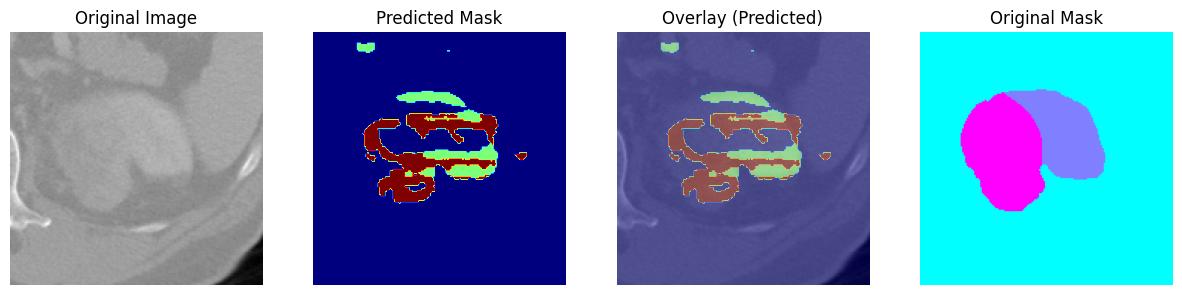

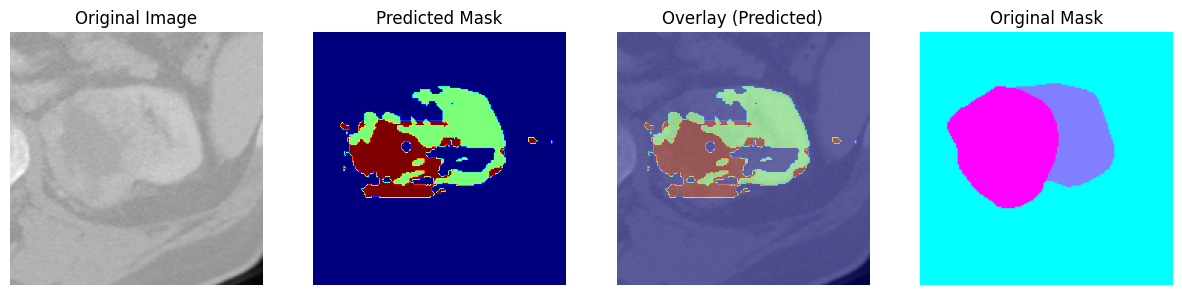

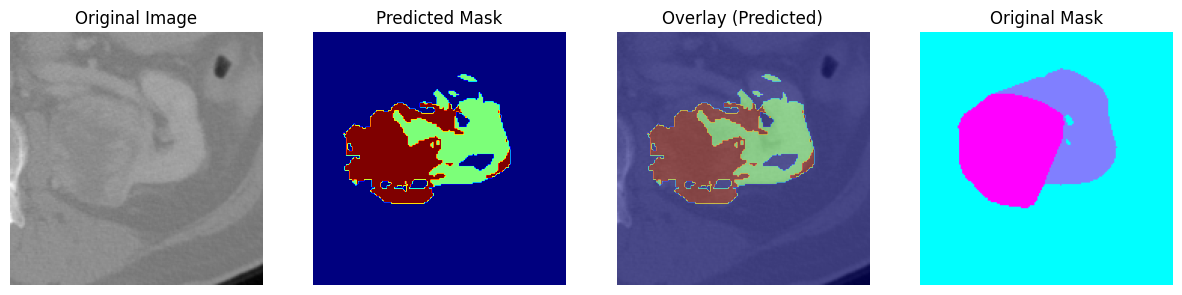

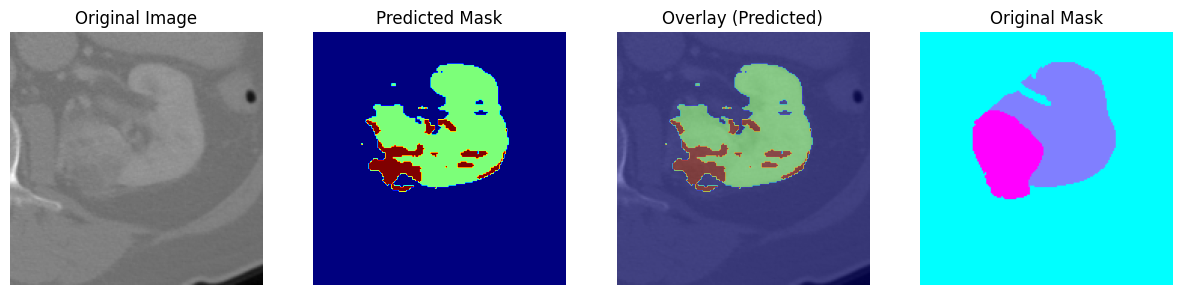

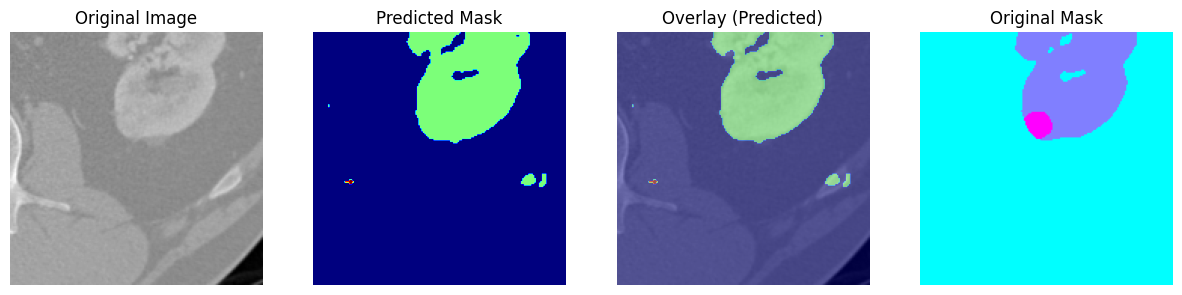

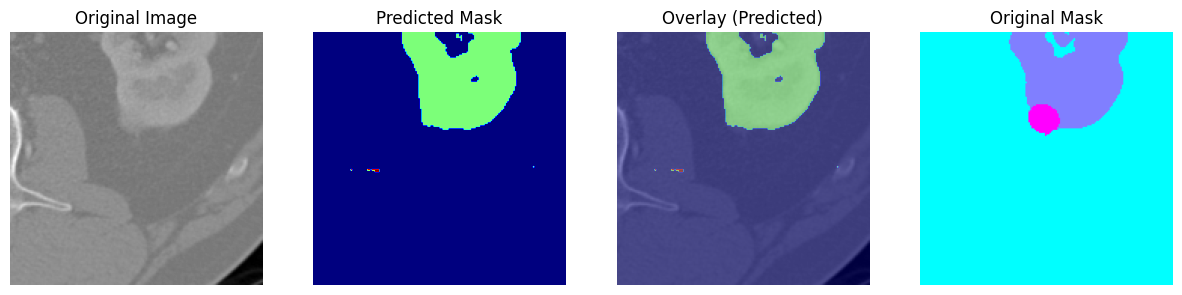

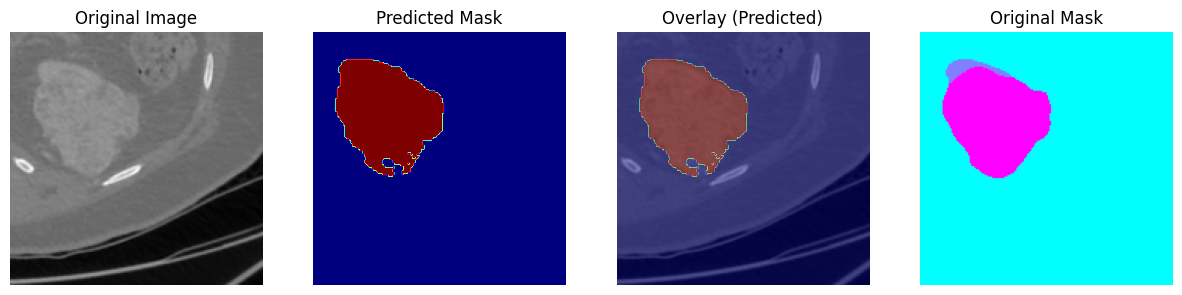

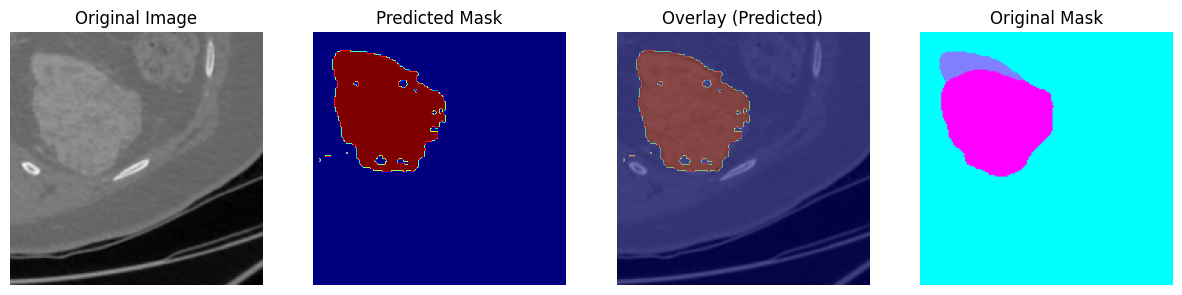

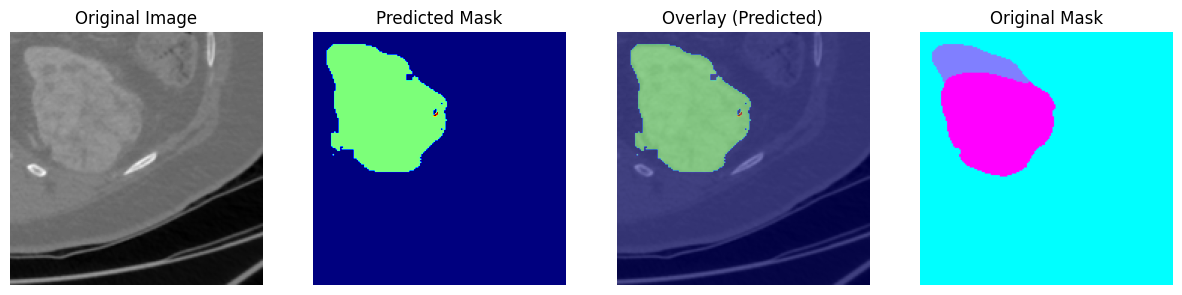

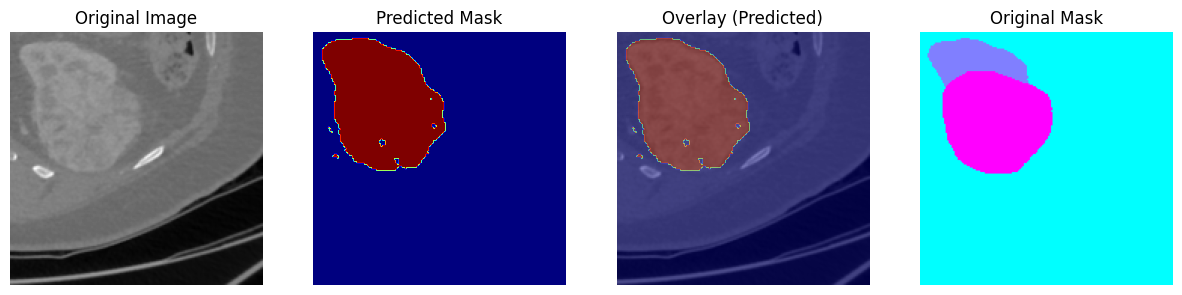

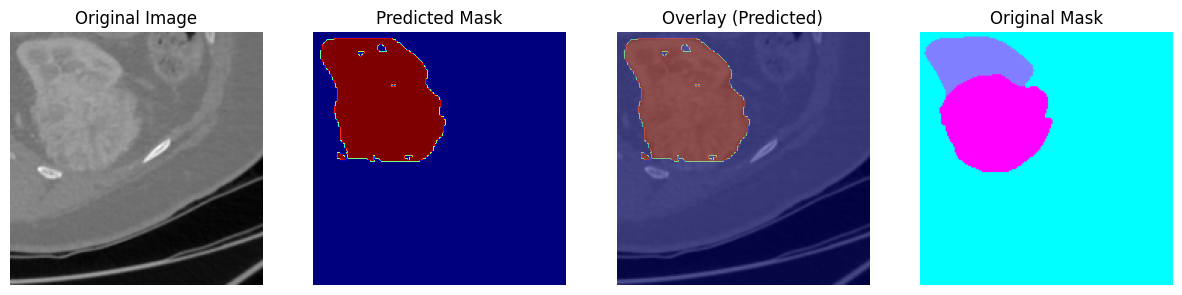

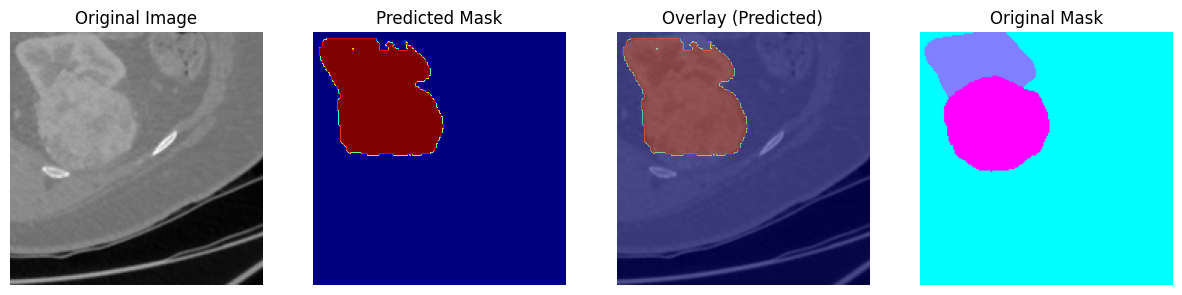

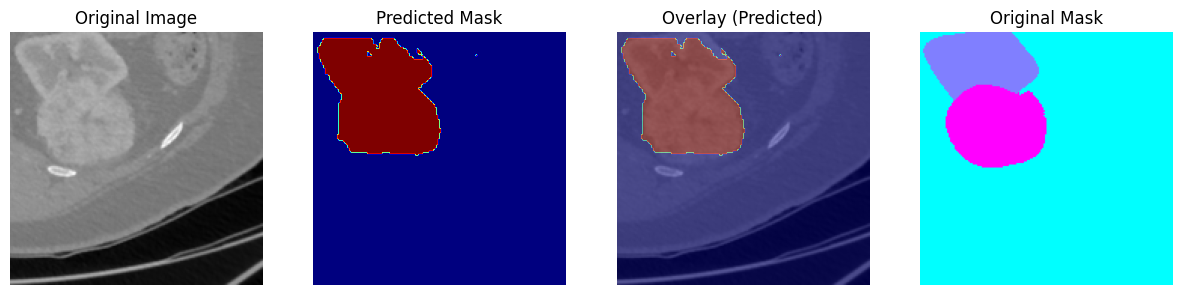

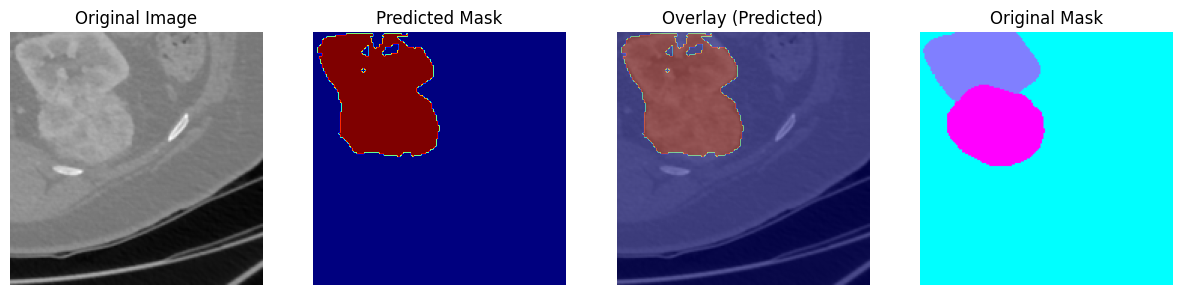

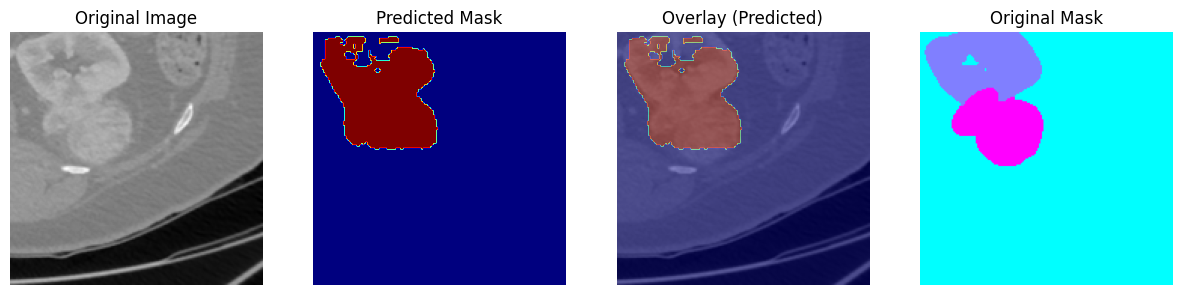

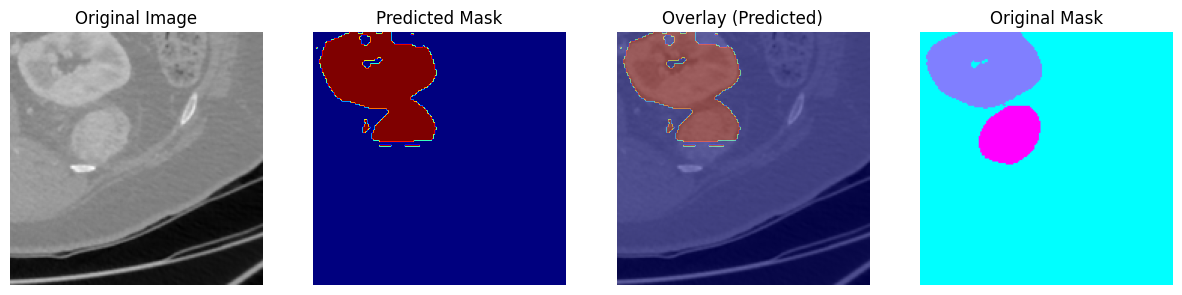

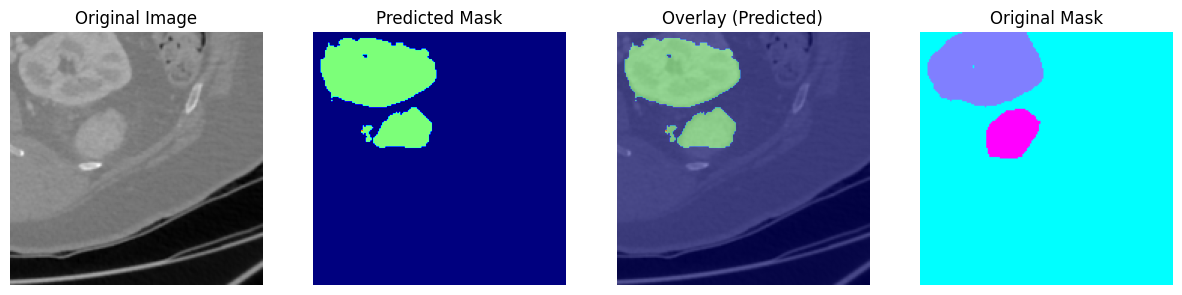

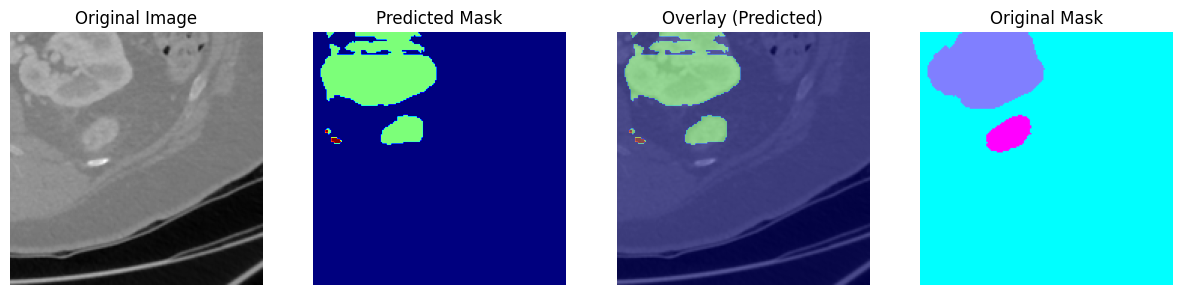

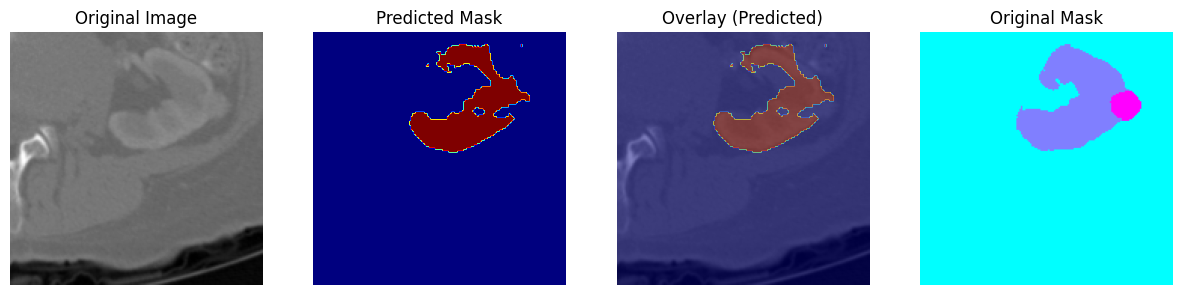

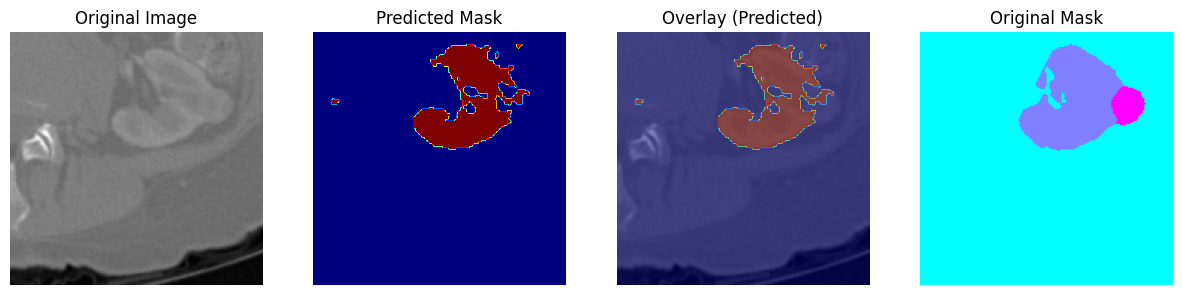

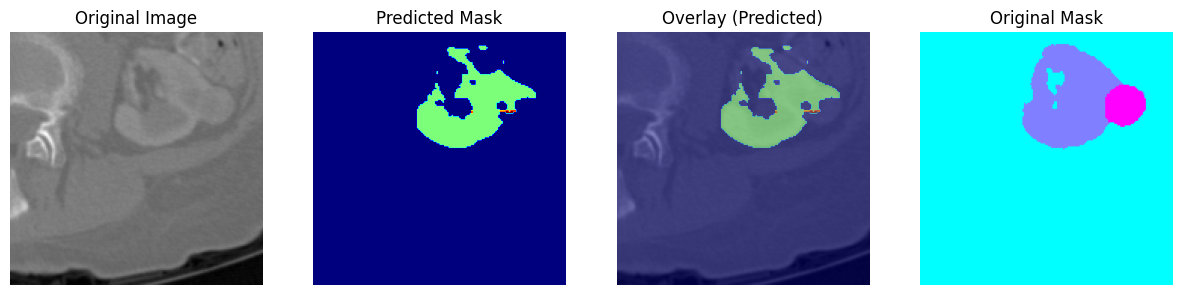

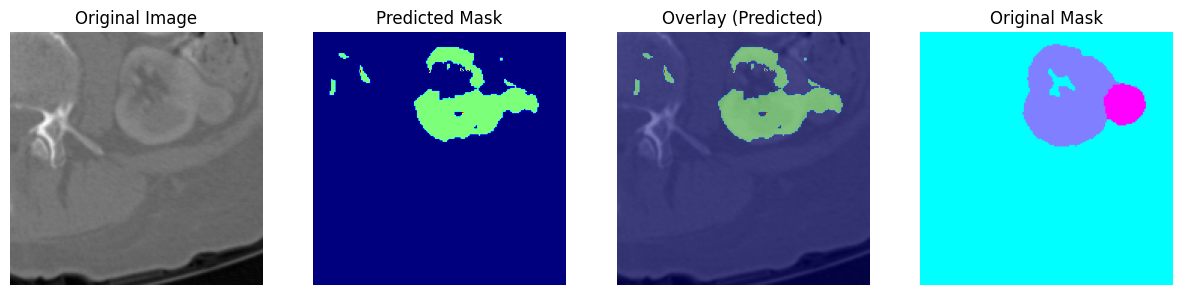

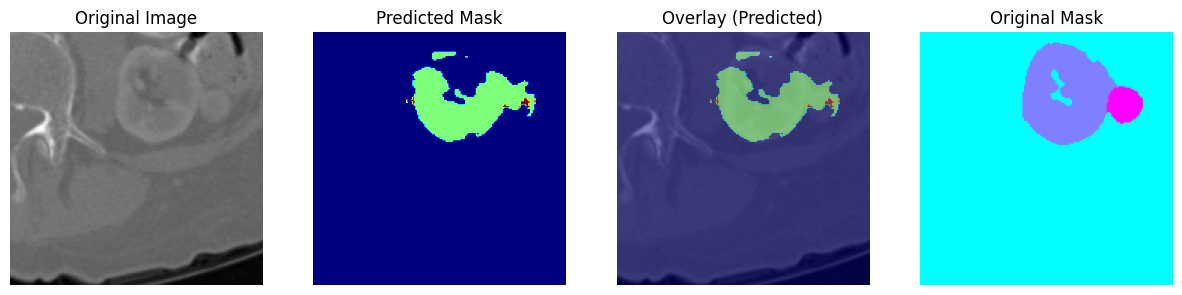

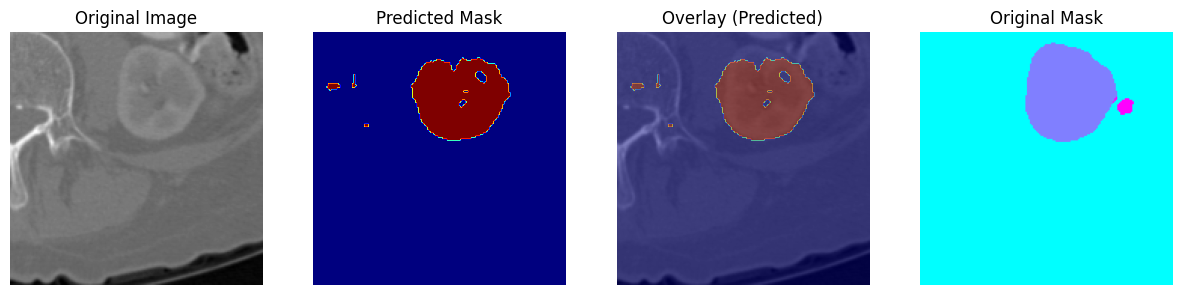

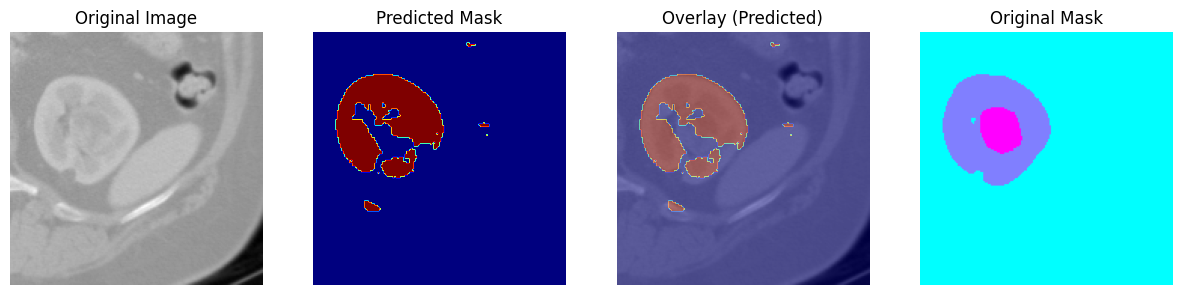

In [ ]:
visualize_segmentation(test_images[indexes], model,test_masks[indexes])